In [146]:
import pandas as pd
import numpy as np
import pycaret.classification as pc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve
import os
from sklearn.metrics import log_loss, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Preparando MLFLOW

In [147]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Projeto Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

# Pré-processamento e EDA

In [148]:
df_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')
data_cols = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
df_dev = df_dev[data_cols]
df_dev = df_dev.dropna()
print(df_dev.head())
print("Dimensão: ",df_dev.shape)
print("Número de registros após a remoção de dados faltantes:", len(df_dev))


       lat       lon  minutes_remaining  period  playoffs  shot_distance  \
1  34.0443 -118.4268                 10       1         0             15   
2  33.9093 -118.3708                  7       1         0             16   
3  33.8693 -118.1318                  6       1         0             22   
4  34.0443 -118.2698                  6       2         0              0   
5  34.0553 -118.4148                  9       3         0             14   

   shot_made_flag  
1             0.0  
2             1.0  
3             0.0  
4             1.0  
5             0.0  
Dimensão:  (20285, 7)
Número de registros após a remoção de dados faltantes: 20285


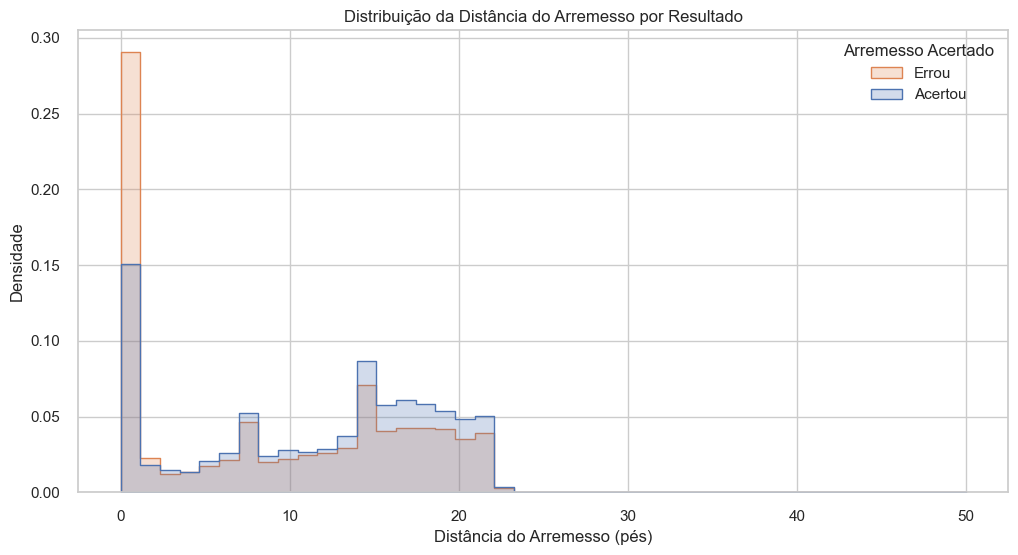

In [149]:
#EDA - Cópia do dataframe para não influenciar em execuções futuras
kobe_data = df_dev.copy()

# 1) Histograma da distância do arremessos
plt.figure(figsize=(12, 6))
sns.histplot(data=kobe_data, x='shot_distance', hue='shot_made_flag', element='step', stat='density', common_norm=False)
plt.title('Distribuição da Distância do Arremesso por Resultado')
plt.xlabel('Distância do Arremesso (pés)')
plt.ylabel('Densidade')
plt.legend(title='Arremesso Acertado', labels=['Errou', 'Acertou'])
plt.show()


##### Quanto a interação dos arremessos vs acertos/erros
- Arremessos acertados tendem a ter maior concentração em distâncias mais curtas, com um pico significativo de 0 a 10 pés. Esse comportamento faz todo sentido, pensando na lógica de distância e dificuldade serem diretamente proporcionais.
- Arremessos errados mostram estão mais esparsos, com um pico em distâncias maiores, especialmente de 15 a 25 pés. Mesmo com esses erros, o Kobe era um jogador muito consistente com relação a acertos.

Conclui-se que shot_distance é uma variável relevante na determinação do sucesso do arremesso, como de práxis.

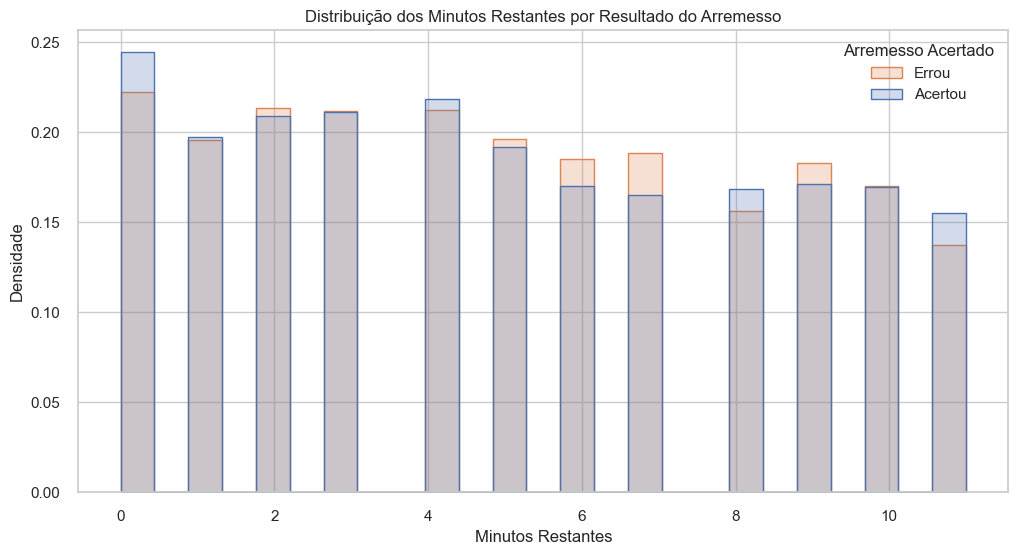

In [150]:
# Criar um histograma dos minutos restantes
plt.figure(figsize=(12, 6))
sns.histplot(data=kobe_data, x='minutes_remaining', hue='shot_made_flag', element='step', stat='density', common_norm=False)
plt.title('Distribuição dos Minutos Restantes por Resultado do Arremesso')
plt.xlabel('Minutos Restantes')
plt.ylabel('Densidade')
plt.legend(title='Arremesso Acertado', labels=['Errou', 'Acertou'])
plt.show()

##### Quanto a interação dos minutos restantes vs acertos/erros
- Minutos restantes mostra um padrão bastante uniforme entre os arremessos acertados e errados, indicando que a variável não é tão discriminativa para prever o sucesso do arremesso quanto shot_distance. 

- Essa análise é interessante pois mostra o quão consiste era o Kobe, mesmo nos períodos finais do jogo, o que provavelmente indica forte resiliência física e mental.

A título de construção de modelo; então, conclui-se que minutes_remaining não é muito útil

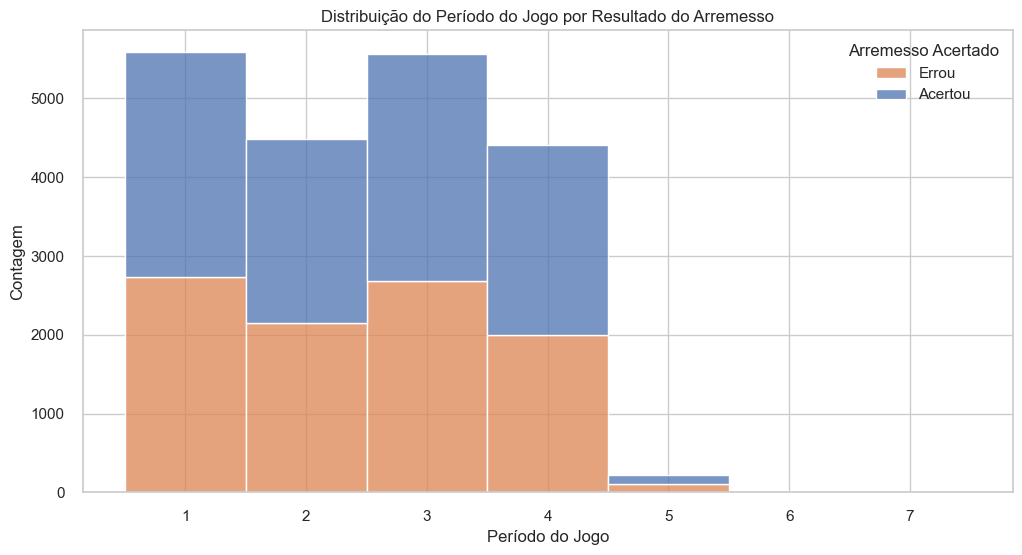

In [151]:
# Criar um histograma do período do jogo
plt.figure(figsize=(12, 6))
sns.histplot(data=kobe_data, x='period', hue='shot_made_flag', multiple='stack', discrete=True)
plt.title('Distribuição do Período do Jogo por Resultado do Arremesso')
plt.xlabel('Período do Jogo')
plt.ylabel('Contagem')
plt.legend(title='Arremesso Acertado', labels=['Errou', 'Acertou'])
plt.show()

##### Quanto a interação dos períodos vs acertos/erros

- Comportamento dessa interação é parecido com a nálise por minutos restante, com a diferença da escala maior. Há uma constância entre quantidade de arremessos e a taxa de sucesso
- Jogos com 5 períodos ou mais são minoria esmagadora no dataset, o que é esperado dado o fato de que um jogo ir à prorrogação é raro.
- Há uma leve disparidade entre sucessos nos primeiros períodos contra os últimos, porém não é tão pronunciada, o que reforça a consistência apontada em análise anterior.

Conclui-se que period também não é uma váriavel relevante para análises.

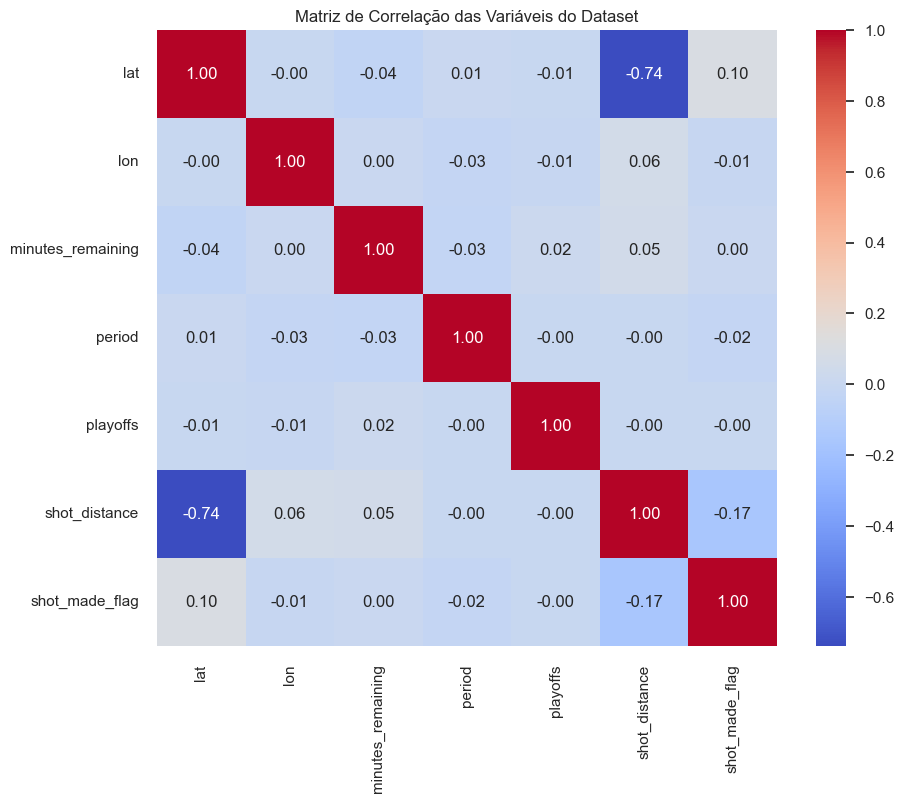

,lat,lon,minutes_remaining,period,playoffs,shot_distance,shot_made_flag
lat,1.000000,-0.003386,-0.039447,0.006389,-0.005229,-0.739249,0.100901
lon,-0.003386,1.000000,0.001915,-0.025566,-0.010779,0.058148,-0.008738
minutes_remaining,-0.039447,0.001915,1.000000,-0.032205,0.018565,0.052097,0.004873
period,0.006389,-0.025566,-0.032205,1.000000,-0.001442,-0.004794,-0.021415
playoffs,-0.005229,-0.010779,0.018565,-0.001442,1.000000,-0.001404,-0.002818
shot_distance,-0.739249,0.058148,0.052097,-0.004794,-0.001404,1.000000,-0.168171
shot_made_flag,0.100901,-0.008738,0.004873,-0.021415,-0.002818,-0.168171,1.000000


In [152]:
#Matriz de correlação
correlation_matrix = kobe_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlação das Variáveis do Dataset')
plt.show()

correlation_matrix

##### Análise de correlações relavantes

- shot_made_flag e shot_distance:
Correlação negativa moderada entre a distância do arremesso e o sucesso, indicado em análises anteriores que arremessos de distâncias maiores têm menor probabilidade de serem bem-sucedidos.

- lat e shot_distance: 
Forte correlação negativa com a distância do arremesso, indicando que posições mais ao norte no campo tendem a estar associadas a arremessos de menor distância. E como já falamos, quanto mais perto mais chance de acertos.

- minutes_remaining e shot_made_flag
Praticamente não há relação entre os minutos restantes e o sucesso do arremesso, indicando que a pressão temporal imediata não tem um grande impacto na eficácia dos arremessos, conforme já mencionado anteriormente esse parece ser um dos fortes do Kobe.

period e shot_made_flag:
- Conclusão:
A análise de correlação reforça que shot_distance é uma variável-chave na previsão do sucesso dos arremessos, com uma relação negativa moderada significativa com shot_made_flag. As outras variáveis mostram correlações muito menores com o sucesso do arremesso, indicando que têm menos influência direta.

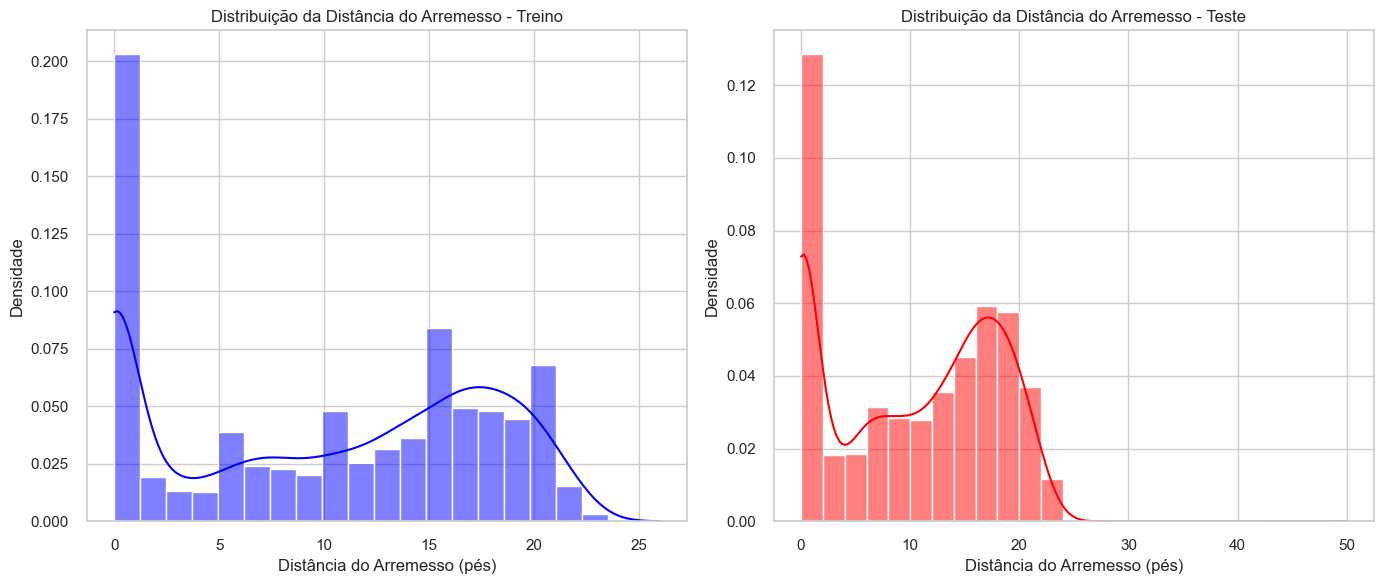

In [153]:
#Testes de distribuição do modelo
train_data, test_data = train_test_split(kobe_data, test_size=0.20, random_state=42)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_data['shot_distance'], kde=True, color='blue', stat='density')
plt.title('Distribuição da Distância do Arremesso - Treino')
plt.xlabel('Distância do Arremesso (pés)')
plt.ylabel('Densidade')
plt.subplot(1, 2, 2)
sns.histplot(test_data['shot_distance'], kde=True, color='red', stat='density')
plt.title('Distribuição da Distância do Arremesso - Teste')
plt.xlabel('Distância do Arremesso (pés)')
plt.ylabel('Densidade')

plt.tight_layout()
plt.show()

##### Considerações gerais sobre divisão treino/teste:

- Ambos os conjuntos exibem tendência similar, com um pico claro em distâncias curtas e menor densidade em distâncias mais longas, conforme já mencionado.
- Ashot_distance é o melhor preditor de sucesso nos arremessos, pois é esperado que arremessos mais próximos ao cesto tenham taxas mais altas de acerto.
- Similaridade de distribuição entre treino e teste com divisão 80/20 é uma excelente notícia.

In [154]:
#Separação em treino/teste e inicialização do MLFOW
train_perc = 0.8

with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):
    
    df_dev = df_dev[data_cols].copy()
    
    df_dev.to_parquet("../data/processed/data_filtered.parquet")
    
    xtrain, xtest, ytrain, ytest = train_test_split(df_dev[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']],
                                                    df_dev['shot_made_flag'],                                                
                                                    train_size=train_perc,
                                                    stratify=df_dev['shot_made_flag'])    
    xtrain['shot_made_flag'] = ytrain
    xtest['shot_made_flag'] = ytest
    xtrain.to_parquet('../data/processed/base_train.parquet')
    xtest.to_parquet('../data/processed/base_test.parquet')

    mlflow.log_params({
        'perc-teste': 1-train_perc,
        'colunas-selecionadas': data_cols
    })
    mlflow.log_metrics({
        'qtd_linhas_treino': xtrain.shape[0],
        'qtd_linhas_teste': xtest.shape[0],
    })

#Responder 6c nos slides

# Treinamento do modelo

In [155]:
def plot_parameter_validation_curve(X, Y, param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = X, 
                                                 y = Y, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=10,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [156]:
registered_model_name = 'model_kobe'
nexamples = 5
model_version = -1

with mlflow.start_run(experiment_id=experiment_id, run_name='Treinamento'):
    exp = pc.setup(
        data=xtrain,
        target='shot_made_flag',
        test_data=xtest,
        normalize=True,
        log_experiment=False
    )
    list_models = exp.compare_models(['lr', 'dt'], n_select=2, sort='f1')

    for model in list_models:
        if isinstance(model, LogisticRegression):
            plt.figure()
            pc.plot_model(model, plot='parameter', save=True)
            plt.savefig('lr_validation_curve.png')
            plt.close()
            mlflow.log_artifact('lr_validation_curve.png')

            yhat_test = exp.predict_model(model)
            fpr, tpr, _ = roc_curve(yhat_test['shot_made_flag'], yhat_test['prediction_score'])
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Curva ROC - Regressão Logística')
            plt.legend(loc='lower right')
            plt.savefig('lr_roc_curve.png')
            plt.close()
            mlflow.log_artifact('lr_roc_curve.png')

        elif isinstance(model, DecisionTreeClassifier):
            plt.figure()
            pc.plot_model(model, plot='parameter', save=True)
            plt.savefig('dt_validation_curve.png')
            plt.close()
            mlflow.log_artifact('dt_validation_curve.png')

            yhat_test = exp.predict_model(model)
            fpr, tpr, _ = roc_curve(yhat_test['shot_made_flag'], yhat_test['prediction_score'])
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Curva ROC Árvore de Decisão')
            plt.legend(loc="lower right")
            plt.savefig('dt_roc_curve.png')
            plt.close()
            mlflow.log_artifact('dt_roc_curve.png')

            mlflow.log_metrics({
                'dt_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test['prediction_label']),
                'dt_f1': f1_score(yhat_test['shot_made_flag'], yhat_test['prediction_label']),
                'dt_roc_auc': roc_auc
            })

    model_pipe = exp.load_model(f'./{registered_model_name}')
    model_features = list(xtrain.drop('shot_made_flag', axis=1).columns)
    inf_signature = infer_signature(xtrain[model_features], model_pipe.predict_proba(xtrain.drop('shot_made_flag', axis=1)))
    input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature=inf_signature,
        input_example=input_example,
        pyfunc_predict_fn='predict_proba'
    )

    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    client.set_registered_model_alias(
        name=registered_model_name,
        alias="staging",
        version=model_version
    )

,Description,Value
0,Session id,6451
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.5393,0.5173,0.5807,0.5153,0.5460,0.0816,0.0823,0.1990
lr,Logistic Regression,0.5765,0.5968,0.4844,0.5658,0.5218,0.1460,0.1474,0.4010


,Parameters
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2
min_weight_fraction_leaf,0.0


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5435,0.5298,0.5901,0.5193,0.5524,0.0905,0.0913


,Parameters
C,1.0
class_weight,None
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,1000
multi_class,auto
n_jobs,None
penalty,l2


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5768,0.6036,0.4775,0.5675,0.5186,0.1460,0.1477


Transformation Pipeline and Model Successfully Loaded


Registered model 'model_kobe' already exists. Creating a new version of this model...
Created version '32' of model 'model_kobe'.


In [ ]:
client = MlflowClient()
model_name = "model_kobe"

# Pegar a última versão do modelo
model_versions = client.get_latest_versions(model_name)
latest_version = model_versions[-1].version  

print(f"Latest version of model '{model_name}' is version {latest_version}")

# Transição para o estágio 'staging'
client.transition_model_version_stage(
    name=model_name,
    version=latest_version,
    stage="staging",
    archive_existing_versions=False  
)

print(f"Model '{model_name}' version {latest_version} has been moved to staging.")


Latest version of model 'model_kobe' is version 31
Model 'model_kobe' version 31 has been moved to staging.


In [158]:
dataset_prod_location = 'C:/Projetos/Projeto Kobe/projeto_kobe/data/raw/dataset_kobe_prod.parquet'

def load_model_from_mlflow(registered_model_name):
    client = MlflowClient()
    model_uri = f"models:/{registered_model_name}/staging"
    model = mlflow.pyfunc.load_model(model_uri)
    return model

prod_data = pd.read_parquet(dataset_prod_location)

with mlflow.start_run(run_name='PipelineAplicacao', experiment_id='2'):
    model = load_model_from_mlflow(registered_model_name)
    
    prod_data['prediction'] = model.predict(prod_data.drop(['shot_made_flag'], axis=1))
    prod_data['prediction_proba'] = model.predict_proba(prod_data.drop(['shot_made_flag'], axis=1))[:, 1]

    new_log_loss = log_loss(prod_data['shot_made_flag'], prod_data['prediction_proba'])
    new_f1_score = f1_score(prod_data['shot_made_flag'], prod_data['prediction'])

    mlflow.log_metrics({'log_loss': new_log_loss, 'f1_score': new_f1_score})

    results_location = "results.parquet"
    prod_data.to_parquet(results_location)
    mlflow.log_artifact(results_location)


ValueError: Expected a 1D array, got an array with shape (6426, 2)